In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)


Using PyTorch version: 2.5.1  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 20

In [4]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())


test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)


100.0%


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
       
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
       
        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [6]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()



In [7]:
def train(model, train_loader, optimizer, log_interval):
    global output, label
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()


        _, prediction = torch.max(output, dim=1 )
        # 정답을 맞춘 갯수
        # acc += sum(idx == label)
        correct += prediction.eq(label.view_as(prediction)).sum().item()


        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))
           
    train_loss /= (len(train_loader.dataset) / BATCH_SIZE)
    train_accuracy = 100. * correct / len(train_loader.dataset)


    return train_loss, train_accuracy


In [8]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0


    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()


    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [9]:
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS
for epoch in range(EPOCHS):
    loss_, acc_ = train(model, train_loader, optimizer, log_interval = 200)
    loss_hist_train[epoch] = loss_
    accuracy_hist_train[epoch] = acc_
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss_hist_valid[epoch] = test_loss
    accuracy_hist_valid[epoch] = test_accuracy
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/tmp/ipykernel_3915/3994585059.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 0 [0/50000 (0%)]	Train Loss: 2.267502
Train Epoch: 0 [6400/50000 (13%)]	Train Loss: 1.817899
Train Epoch: 0 [12800/50000 (26%)]	Train Loss: 1.806706
Train Epoch: 0 [19200/50000 (38%)]	Train Loss: 2.042279
Train Epoch: 0 [25600/50000 (51%)]	Train Loss: 1.563587
Train Epoch: 0 [32000/50000 (64%)]	Train Loss: 1.325174
Train Epoch: 0 [38400/50000 (77%)]	Train Loss: 1.578195
Train Epoch: 0 [44800/50000 (90%)]	Train Loss: 1.622741

[EPOCH: 0], 	Test Loss: 1.4848, 	Test Accuracy: 45.25 % 

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 1.438042
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.483111
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.237920
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.144354
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.403077
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.164293
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.606549
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.456077

[EPOCH: 1], 	Test Loss: 1.3511, 	Test Accuracy: 51.04 % 

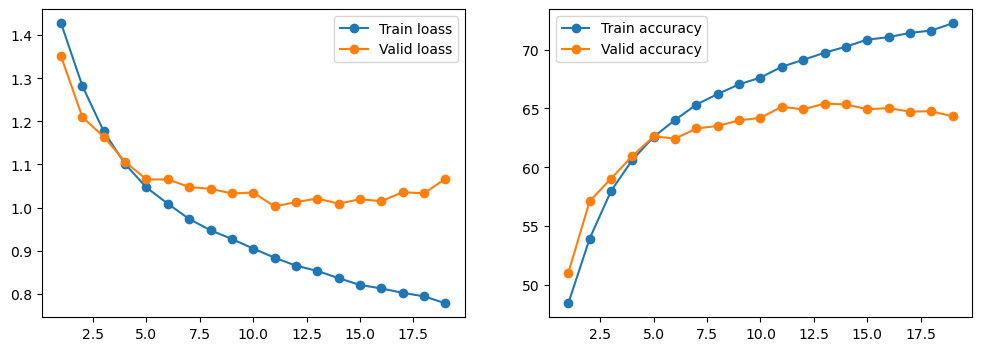

In [10]:
x_arr = np.arange(len(loss_hist_train[1:])) + 1    
#accuracy_hist_train
#loss_hist_valid [1:]  
#accuracy_hist_valid
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr,loss_hist_train[1:], '-o', label='Train loass' )
ax.plot(x_arr,loss_hist_valid[1:], '-o', label='Valid loass' )
ax.legend()


ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr,accuracy_hist_train[1:], '-o', label='Train accuracy' )
ax.plot(x_arr,accuracy_hist_valid[1:], '-o', label='Valid accuracy' )
ax.legend()
plt.show()

In [24]:
class test:
  def __init(self):
    pass
  def __str__(self):
    return "hi"


  def __call__(self):
    print("call 호출")  

In [25]:
t = test()

In [26]:
print(t)

hi


In [27]:
t()

call 호출


In [ ]:
class early_stopping:
    def __int__(self, patience. verbose, delta):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.count = 0
        self.best_score = None
        self.early_stop = False
        self.val_

In [ ]:
class early_stopping:
    def __init__(self, patience, verbose, delta, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.count = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.count +=1
            if self.verbos:
                print(f"Early Stopping counter: {self.count} out of {self.patience}")
            if self.count >= self.patience:
                self.early_stop = True  
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.count =0 

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f}) --> {val_loss:.6f}. saving model..")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss